# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import graphviz
from datetime import date
import time
import pyreadr

import os
import math
from math import sqrt

# Tensorflow and Keras
from keras.layers import Concatenate, Input, LSTM, Dense
from keras.layers import Dropout, Flatten, Reshape, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.activations import softmax
from keras.callbacks import EarlyStopping

import tensorflow as tf
from keras import backend as K

print(tf.__version__) # 2.6.0
print(tf.config.list_physical_devices('GPU'))

import joblib

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data for RF

In [3]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)
MG = MG.astype(float).astype(int)

# Transform Genotype into ClusterID
# Genotype = df_train['Genotype'].astype('category')
# Genotype = Genotype.to_numpy()
# Genotype = Genotype.astype(float).astype(int)
# K = np.empty(len(Genotype))
# for i in range(len(ClusterID)):
#     K[Genotype==i] = ClusterID[i]
# K = K.reshape(-1,1)
# K = K.astype(int)

# Standardization prcess
scaler_x0 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,1])
scaled_x1 = scaler_x1.transform(Weather_train[:,:,1])
scaler_x2 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,2])
scaled_x2 = scaler_x2.transform(Weather_train[:,:,2])
scaler_x3 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,3])
scaled_x3 = scaler_x3.transform(Weather_train[:,:,3])
scaler_x4 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,4])
scaled_x4 = scaler_x4.transform(Weather_train[:,:,4])
scaler_x5 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,5])
scaled_x5 = scaler_x5.transform(Weather_train[:,:,5])
scaler_x6 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,6])
scaled_x6 = scaler_x6.transform(Weather_train[:,:,6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])

# Transform into series data
print(X.shape)

X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))

print(X.shape)

X = np.hstack((X, MG))
# X = np.hstack((X, MG, K))

#####################################
# Load training and validation data #
#####################################
# 30% is val, 70% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.2, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''
Weather_test = np.load('./Dataset_Competition/Test Inputs/inputs_weather_test.npy')

df_test = np.load('./Dataset_Competition/Test Inputs/inputs_others_test.npy')
df_test = pd.DataFrame(df_test, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG_test = df_test['MG'].astype('category')
MG_test = MG_test.to_numpy()
MG_test = MG_test.reshape(-1,1)
MG_test = MG_test.astype(float).astype(int)

# Standardization prcess
scaled_x0 = scaler_x0.transform(Weather_test[:,:,0])
scaled_x1 = scaler_x1.transform(Weather_test[:,:,1])
scaled_x2 = scaler_x2.transform(Weather_test[:,:,2])
scaled_x3 = scaler_x3.transform(Weather_test[:,:,3])
scaled_x4 = scaler_x4.transform(Weather_test[:,:,4])
scaled_x5 = scaler_x5.transform(Weather_test[:,:,5])
scaled_x6 = scaler_x6.transform(Weather_test[:,:,6])
X_test2 = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])

# Transform into series data
print(X_test2.shape)

X_test2 = X_test2.reshape((X_test2.shape[0],X_test2.shape[1]*X_test2.shape[2]))

print(X_test2.shape)

X_test2 = np.hstack((X_test2, MG_test))

(93028, 214, 7)
(93028, 1498)
(10337, 214, 7)
(10337, 1498)


In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_test2.shape)

(74422, 1499)
(9303, 1499)
(9303, 1499)
(10337, 1499)


# Random Forest Regression

In [5]:
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("./model_scikit/random_forest.joblib")

rf_pred_train = loaded_rf.predict(X_train)
rf_pred_val = loaded_rf.predict(X_val)
rf_pred_test = loaded_rf.predict(X_test)
rf_pred_test2 = loaded_rf.predict(X_test2)

rf_pred_train = rf_pred_train.reshape(-1,1)
rf_pred_val = rf_pred_val.reshape(-1,1)
rf_pred_test = rf_pred_test.reshape(-1,1)
rf_pred_test2 = rf_pred_test2.reshape(-1,1)

In [6]:
print(rf_pred_train.shape)
print(rf_pred_val.shape)
print(rf_pred_test.shape)
print(rf_pred_test2.shape)

(74422, 1)
(9303, 1)
(9303, 1)
(10337, 1)


# Load data for CNN LSTM

In [16]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)
scaler_MG = MinMaxScaler(feature_range = (0, 1)).fit(MG)
MG = scaler_MG.transform(MG)
tileMG = np.tile(MG, 214)

# Transform Genotype into ClusterID, and stack with MG
# Genotype = df_train['Genotype'].astype('category')
# Genotype = Genotype.to_numpy()
# K = np.empty(len(Genotype))
# for i in range(len(ClusterID)):
#     K[Genotype==i] = ClusterID[i]
# K = K.reshape(-1,1)
# MG = np.hstack([MG, K])

# Standardization prcess
scaler_x0 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,1])
scaled_x1 = scaler_x1.transform(Weather_train[:,:,1])
scaler_x2 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,2])
scaled_x2 = scaler_x2.transform(Weather_train[:,:,2])
scaler_x3 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,3])
scaled_x3 = scaler_x3.transform(Weather_train[:,:,3])
scaler_x4 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,4])
scaled_x4 = scaler_x4.transform(Weather_train[:,:,4])
scaler_x5 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,5])
scaled_x5 = scaler_x5.transform(Weather_train[:,:,5])
scaler_x6 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,6])
scaled_x6 = scaler_x6.transform(Weather_train[:,:,6])
# X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6, tileMG])

Y = Y.reshape(-1,1)
scaler_Y = MinMaxScaler(feature_range = (0, 1)).fit(Y)
Y = scaler_Y.transform(Y)

# Trancation
X = X[:,np.arange(0,214,7),:] 

#####################################
# Load training and validation data #
#####################################
# 10% is test, 10% is val, 80% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.2, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

MG_train, MG_val = train_test_split(MG, test_size=0.2, shuffle=True, random_state=888)
MG_val, MG_test = train_test_split(MG_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''
Weather_test = np.load('./Dataset_Competition/Test Inputs/inputs_weather_test.npy')

df_test = np.load('./Dataset_Competition/Test Inputs/inputs_others_test.npy')
df_test = pd.DataFrame(df_test, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG_test2 = df_test['MG'].astype('category')
MG_test2 = MG_test2.to_numpy()
MG_test2 = MG_test2.reshape(-1,1)
MG_test2 = scaler_MG.transform(MG_test2)
tileMG_test2 = np.tile(MG_test2, 214)

# Standardization prcess
scaled_x0 = scaler_x0.transform(Weather_test[:,:,0])
scaled_x1 = scaler_x1.transform(Weather_test[:,:,1])
scaled_x2 = scaler_x2.transform(Weather_test[:,:,2])
scaled_x3 = scaler_x3.transform(Weather_test[:,:,3])
scaled_x4 = scaler_x4.transform(Weather_test[:,:,4])
scaled_x5 = scaler_x5.transform(Weather_test[:,:,5])
scaled_x6 = scaler_x6.transform(Weather_test[:,:,6])
X_test2 = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6, tileMG_test2])

# Trancation
X_test2 = X_test2[:,np.arange(0,214,7),:] 

# Transform into tensor
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')
X_test2 = X_test2.astype('float')

MG_train = MG_train.astype('float')
MG_val = MG_val.astype('float')
MG_test = MG_test.astype('float')
MG_test2 = MG_test2.astype('float')

In [17]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_test2.shape)

(74422, 31, 8)
(9303, 31, 8)
(9303, 31, 8)
(10337, 31, 8)


# Load model and predict

In [18]:
batch_size = 512

# Load model should be revised for keras
filepath = './model_keras/LSTM_BestKerasModel'
reconstructed_model  = tf.keras.models.load_model(filepath)

pred_train = reconstructed_model.predict([X_train, MG_train], batch_size = batch_size)
pred_val = reconstructed_model.predict([X_val, MG_val], batch_size = batch_size)
pred_test = reconstructed_model.predict([X_test, MG_test], batch_size = batch_size)
pred_test2 = reconstructed_model.predict([X_test2, MG_test2], batch_size = batch_size)

# Inverse transform
cnn_lstm_pred_train = scaler_Y.inverse_transform(pred_train)
cnn_lstm_pred_val = scaler_Y.inverse_transform(pred_val)
cnn_lstm_pred_test = scaler_Y.inverse_transform(pred_test)
cnn_lstm_pred_test2 = scaler_Y.inverse_transform(pred_test2)

inv_Y_train = scaler_Y.inverse_transform(Y_train)
inv_Y_val = scaler_Y.inverse_transform(Y_val)
inv_Y_test = scaler_Y.inverse_transform(Y_test)

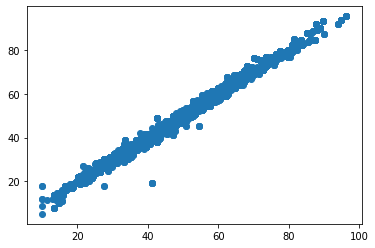

In [48]:
plt.scatter(cnn_lstm_pred_test2, rf_pred_test2)

# Emsamble Learning

In [19]:
# pred_train = np.hstack([rf_pred_train, cnn_lstm_pred_train])
# pred_train = pd.DataFrame(pred_train)
# pred_train = pred_train.mean(axis='columns')

# pred_val = np.hstack([rf_pred_val, cnn_lstm_pred_val])
# pred_val = pd.DataFrame(pred_val)
# pred_val = pred_val.mean(axis='columns')

# pred_test = np.hstack([rf_pred_test, cnn_lstm_pred_test])
# pred_test = pd.DataFrame(pred_test)
# pred_test = pred_test.mean(axis='columns')

In [50]:
from sklearn.linear_model import LinearRegression

stack_train = np.hstack([rf_pred_train, cnn_lstm_pred_train])
print(stack_train.shape)
# stack_train = pd.DataFrame(stack_train)

stack_val = np.hstack([rf_pred_val, cnn_lstm_pred_val])
print(stack_val.shape)
# stack_val = pd.DataFrame(stack_val)

stack_test = np.hstack([rf_pred_test, cnn_lstm_pred_test])
print(stack_test.shape)
# stack_test = pd.DataFrame(stack_test)

stack_test2 = np.hstack([rf_pred_test2, cnn_lstm_pred_test2])
print(stack_test2.shape)
# stack_test = pd.DataFrame(stack_test)

meta_model = LinearRegression()
meta_model.fit(stack_train, inv_Y_train)
print(meta_model.coef_)
print(meta_model.intercept_)
print(meta_model.get_params())

print(stack_train.shape)
pred_train = meta_model.predict(stack_train)
pred_val = meta_model.predict(stack_val)
pred_test = meta_model.predict(stack_test)
pred_test2 = meta_model.predict(stack_test2)


print(pred_train.shape)
print(pred_val.shape)
print(pred_test.shape)
print(pred_test2.shape)


(74422, 2)
(9303, 2)
(9303, 2)
(10337, 2)
[[9.99496710e-01 3.62411135e-04]]
[0.00773926]
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
(74422, 2)
(74422, 1)
(9303, 1)
(9303, 1)
(10337, 1)


In [51]:
print(inv_Y_train.shape)
print(inv_Y_val.shape)
print(inv_Y_test.shape)

(74422, 1)
(9303, 1)
(9303, 1)


Train


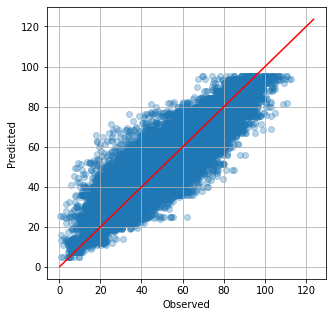

Validation


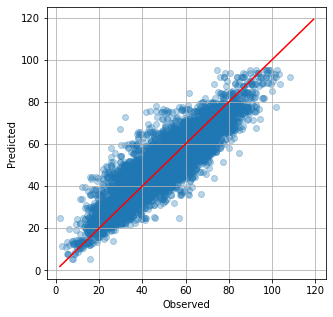

Test


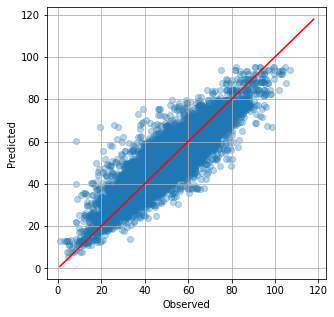

Train RMSE: 7.02
Train MAE: 5.28
Train R2: 0.806
Validation RMSE: 7.12
Validation MAE: 5.38
Validation R2: 0.802
Test RMSE: 7.24
Test MAE: 5.43
Test R2: 0.796


In [53]:

# # Plotting model results
print("Train")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_train, pred_train, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_train).item(), 1.1*max(inv_Y_train).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Validation")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_val, pred_val, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_val).item(), 1.1*max(inv_Y_val).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_test, pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_test).item(), 1.1*max(inv_Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Train RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_train, pred_train))))
print("Train MAE: %.2f" % (mean_absolute_error(inv_Y_train, pred_train)))
print("Train R2: %.3f" % (r2_score(inv_Y_train, pred_train)))

print("Validation RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_val, pred_val))))
print("Validation MAE: %.2f" % (mean_absolute_error(inv_Y_val, pred_val)))
print("Validation R2: %.3f" % (r2_score(inv_Y_val, pred_val)))

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_test, pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(inv_Y_test, pred_test)))
print("Test R2: %.3f" % (r2_score(inv_Y_test, pred_test)))

In [54]:
pred_test2 = pred_test2.reshape(-1)
pred_test2.shape

(10337,)

(array([  70.,  236.,  751., 1587., 2495., 2446., 1705.,  735.,  215.,
          97.]),
 array([ 5.21749897, 14.22738326, 23.23726756, 32.24715185, 41.25703615,
        50.26692045, 59.27680474, 68.28668904, 77.29657333, 86.30645763,
        95.31634193]),
 <BarContainer object of 10 artists>)

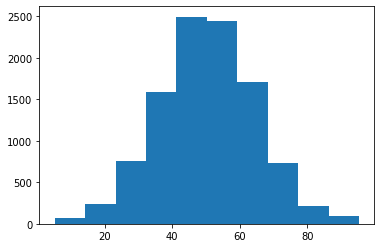

In [55]:
plt.hist(pred_test2)

In [57]:
np.save('Dataset_Competition/output/pred_test_20211025_2', pred_test2)